In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imbalanced-learn openpyxl

In [29]:

from collections import Counter

import h5py

from imblearn.over_sampling import SMOTE

import numpy as np

import matplotlib.pyplot as plt

import os

import pandas as pd

from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, log_loss, top_k_accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

# import torch
# import torch.nn as nn
# import torch.optim as optim

from tqdm.auto import tqdm

In [34]:
data_df = pd.read_csv(
    "../../TargetMol-CP3/TargetMol-CP3/FrozenVersions/TargetMol_1-27_1uM+10uM_PMA_horizconcat_HDpy_IDnames.csv",
#     "../../TargetMol-CP3/TargetMol-CP3/FrozenVersions/TargetMol_1-27_1uM+10uM_PMA+noPMA_horizconcat_HD_IDnames.csv",
#     "/content/drive/Shareddrives/CP3/TargetMol/FrozenVersions/TargetMol_1-27_1uM+10uM_PMA+noPMA_horizconcat_HD_IDnames.csv",
    # "/content/drive/MyDrive/Aa_Lokey_Lab/TargetMol/FrozenVersions/TargetMol_10uM_PMA+DMSO_HistDiff_horizconcat_IDnames.csv",
                      index_col=0,
                      )

In [35]:
values_df = pd.read_excel(
    "../../TargetMol-CP3/TargetMol-CP3/AnnotationWork/GPT annotations/reducedKey_cytoscapeAnnot.xlsx",
#     "/content/drive/Shareddrives/CP3/TargetMol/AnnotationWork/GPT annotations/reducedKey_cytoscapeAnnot.xlsx",
    # '/content/drive/Shareddrives/CP3/TargetMol/AnnotationWork/GPT annotations/reducedKey_cytoscapeAnnot.xlsx',
                    index_col='IDname',
                    sheet_name='reducedKey',
                    )

In [36]:
df = pd.merge(left=data_df,right=values_df['AL_CONSOLIDATED'],left_index=True,right_index=True)

In [37]:
df

,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Mean_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_StdDev_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Median_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Maximum_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Minimum_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Sum_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_CV_[Pct]_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Quantile_90Pct_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Contrast_PMA,Nuclei-Nucleus_Region_Area_[um^2]_PMA,...,Nuclei-Membrane_Region_MitoTracker_Deep_Red_SER_Saddle_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_SER_Bright_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_SER_Dark_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Correlation_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Contrast_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Sum_Variance_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Homogeneity_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Gabor_Min_2_px_w2_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Gabor_Max_2_px_w2_PMA,AL_CONSOLIDATED
DMSO._.NA._.A01._.SP7201,-0.001183,0.000748,0.000127,0.000186,0.000354,0.006467,-0.005407,0.000099,-0.020500,0.008449,...,-0.283609,-0.055801,-0.245371,0.169670,-0.046752,3.526622e-04,0.235398,-0.060292,-0.088151,Collected_Controls
DMSO._.NA._.A01._.SP7202,-0.001054,-0.012746,-0.002486,-0.006576,0.000193,0.000045,-0.014441,-0.007188,-0.017577,0.015990,...,-0.345183,-0.031406,-0.278377,0.208430,-0.000047,5.690639e-06,0.244385,-0.047646,-0.065632,Collected_Controls
DMSO._.NA._.A01._.SP7203,-0.001047,-0.002379,0.000004,-0.000647,-0.000440,0.002201,-0.006870,0.000134,-0.012484,0.010209,...,-0.298550,-0.049099,-0.245935,0.185864,-0.045130,1.601523e-03,0.196514,-0.036202,-0.048343,Collected_Controls
DMSO._.NA._.A01._.SP7204,0.000891,-0.006452,-0.001968,-0.001899,-0.001719,0.010389,-0.012897,-0.003504,-0.004702,0.009413,...,-0.177117,-0.027953,-0.144210,0.123386,-0.000160,-6.939387e-05,0.133873,-0.032752,-0.039716,Collected_Controls
DMSO._.NA._.A01._.SP7205,0.000366,-0.007824,-0.008492,-0.005391,-0.008540,0.000000,-0.010715,-0.009327,-0.010539,0.005144,...,-0.160605,-0.025120,-0.146287,0.150765,-0.000238,7.235529e-05,0.147292,-0.024461,-0.038410,Collected_Controls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T5428._.10uM._.P04._.SP7237,-0.000894,0.000289,-0.002071,0.000703,-0.001166,-0.004472,0.001531,-0.000682,0.000495,-0.002129,...,-0.001659,0.008145,0.000170,0.013188,-0.001646,1.830123e-06,0.001779,0.003210,0.001946,Leucine-rich_repeat_kinase_2
T5468._.10uM._.P06._.SP7237,-0.000558,-0.000016,-0.000240,-0.001210,-0.000205,-0.003476,0.000325,-0.000355,-0.002993,-0.005354,...,0.005377,-0.008721,0.005234,-0.002536,0.002149,-9.549408e-07,-0.002750,-0.000320,-0.000004,Epigenetic_Reader_Domain
T6603._.10uM._.P07._.SP7237,-0.000031,0.000052,-0.000035,-0.000132,-0.000039,0.000223,-0.000090,-0.000054,-0.000828,0.000630,...,-0.000626,-0.002695,0.000129,-0.000510,-0.000141,3.415374e-06,-0.000125,-0.000173,-0.001620,Deoxyguanosine_kinase
T5400._.10uM._.P08._.SP7237,0.000430,-0.000076,0.000243,0.000154,0.001001,-0.000022,-0.001700,0.000455,-0.003754,-0.000121,...,0.000371,-0.002490,0.001295,-0.000580,-0.000297,6.050463e-06,0.000547,0.000275,-0.000006,Cytochrome


In [38]:
# Remove rows with NaN
df = df.dropna()
X = df.iloc[:, :-1].values
y = df['AL_CONSOLIDATED'].values.reshape(-1,1)
classed_to_consider = [x for x in values_df['AL_CONSOLIDATED'].value_counts()[values_df['AL_CONSOLIDATED'].value_counts()>100].index.to_list()]
y_special = [y if y in classed_to_consider else 'Others' for y in df['AL_CONSOLIDATED']]
print(len(classed_to_consider))

86


In [42]:
# [ix for ix in globals().keys() if not ix.startswith('_')]
df

,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Mean_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_StdDev_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Median_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Maximum_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Minimum_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Sum_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_CV_[Pct]_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Quantile_90Pct_PMA,Nuclei-Intensity_Nucleus_Region_HOECHST_33342_expanded_Contrast_PMA,Nuclei-Nucleus_Region_Area_[um^2]_PMA,...,Nuclei-Membrane_Region_MitoTracker_Deep_Red_SER_Saddle_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_SER_Bright_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_SER_Dark_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Correlation_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Contrast_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Sum_Variance_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Haralick_Homogeneity_2_px_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Gabor_Min_2_px_w2_PMA,Nuclei-Membrane_Region_MitoTracker_Deep_Red_Gabor_Max_2_px_w2_PMA,AL_CONSOLIDATED
DMSO._.NA._.A01._.SP7201,-0.001183,0.000748,0.000127,0.000186,0.000354,0.006467,-0.005407,0.000099,-0.020500,0.008449,...,-0.283609,-0.055801,-0.245371,0.169670,-0.046752,3.526622e-04,0.235398,-0.060292,-0.088151,Collected_Controls
DMSO._.NA._.A01._.SP7202,-0.001054,-0.012746,-0.002486,-0.006576,0.000193,0.000045,-0.014441,-0.007188,-0.017577,0.015990,...,-0.345183,-0.031406,-0.278377,0.208430,-0.000047,5.690639e-06,0.244385,-0.047646,-0.065632,Collected_Controls
DMSO._.NA._.A01._.SP7203,-0.001047,-0.002379,0.000004,-0.000647,-0.000440,0.002201,-0.006870,0.000134,-0.012484,0.010209,...,-0.298550,-0.049099,-0.245935,0.185864,-0.045130,1.601523e-03,0.196514,-0.036202,-0.048343,Collected_Controls
DMSO._.NA._.A01._.SP7204,0.000891,-0.006452,-0.001968,-0.001899,-0.001719,0.010389,-0.012897,-0.003504,-0.004702,0.009413,...,-0.177117,-0.027953,-0.144210,0.123386,-0.000160,-6.939387e-05,0.133873,-0.032752,-0.039716,Collected_Controls
DMSO._.NA._.A01._.SP7205,0.000366,-0.007824,-0.008492,-0.005391,-0.008540,0.000000,-0.010715,-0.009327,-0.010539,0.005144,...,-0.160605,-0.025120,-0.146287,0.150765,-0.000238,7.235529e-05,0.147292,-0.024461,-0.038410,Collected_Controls
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T5428._.10uM._.P04._.SP7237,-0.000894,0.000289,-0.002071,0.000703,-0.001166,-0.004472,0.001531,-0.000682,0.000495,-0.002129,...,-0.001659,0.008145,0.000170,0.013188,-0.001646,1.830123e-06,0.001779,0.003210,0.001946,Leucine-rich_repeat_kinase_2
T5468._.10uM._.P06._.SP7237,-0.000558,-0.000016,-0.000240,-0.001210,-0.000205,-0.003476,0.000325,-0.000355,-0.002993,-0.005354,...,0.005377,-0.008721,0.005234,-0.002536,0.002149,-9.549408e-07,-0.002750,-0.000320,-0.000004,Epigenetic_Reader_Domain
T6603._.10uM._.P07._.SP7237,-0.000031,0.000052,-0.000035,-0.000132,-0.000039,0.000223,-0.000090,-0.000054,-0.000828,0.000630,...,-0.000626,-0.002695,0.000129,-0.000510,-0.000141,3.415374e-06,-0.000125,-0.000173,-0.001620,Deoxyguanosine_kinase
T5400._.10uM._.P08._.SP7237,0.000430,-0.000076,0.000243,0.000154,0.001001,-0.000022,-0.001700,0.000455,-0.003754,-0.000121,...,0.000371,-0.002490,0.001295,-0.000580,-0.000297,6.050463e-06,0.000547,0.000275,-0.000006,Cytochrome


In [21]:
X_dr = PCA(n_components=32).fit_transform(X)

In [41]:
# sm=SMOTE(random_state=137)
# X_smote, y_smote = sm.fit_resample(X_dr,y_special)
# print(f"Resampled dataset shape {Counter(y_smote)}")
# X_smote, y_smote = X_dr,y_special
X_smote,y_smote = X,y_special
print(len(X_smote))

19097


In [43]:
y_special_encoded = LabelEncoder().fit_transform(y_smote)
# y_special_out = y_special.transform(combined['AL_CONSOLIDATED'])
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_special_encoded, test_size=0.3, shuffle=True)
X_train = np.array(X_train[:])
y_train = np.array(y_train[:])
print(X_train.shape)
print(y_train.shape)

(13367, 5880)
(13367,)


In [53]:
# import os
# from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, log_loss, top_k_accuracy_score, balanced_accuracy_score
# ExtraTreesClassifier
clf = RandomForestClassifier(random_state=137, verbose=True, n_jobs=os.cpu_count()-2)

clf.fit(X_train, y_train)
clf.score(X_test, y_test)

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:   47.1s finished
[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.1s finished


0.43595113438045374

In [61]:
# Evaluate with all sklearn classifier metrics
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
# print(f"top_k_acc: {top_k_accuracy_score(y_test,y_pred,k=5)}:.4f")

[Parallel(n_jobs=30)]: Using backend ThreadingBackend with 30 concurrent workers.


Accuracy: 0.4360
Precision: 0.3033
F1-score: 0.3145
Recall: 0.4360


[Parallel(n_jobs=30)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\ProgramData\Miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [62]:
def rank_of_correct_label(y_true, y_pred_proba):
    # This function computes the rank of the true label for each test sample based on predicted probabilities
    ranks = []
    for true_label, probabilities in zip(y_true, y_pred_proba):
        # Sort probabilities in descending order and get the indices
        sorted_indices = np.argsort(probabilities)[::-1]
        # Find the rank (index position in the sorted array) of the true label
        rank = np.where(sorted_indices == true_label)[0][0] + 1  # +1 to make it 1-based index
        ranks.append(rank)
    return ranks

In [63]:
# Standard balanced accuracy
def balanced_accuracy(y_true, y_pred, **kwargs):
    return balanced_accuracy_score(y_true, y_pred)

print(y_test, len(y_test))
print(y_pred, len(y_pred))
print((y_test==y_pred), (y_test==y_pred).sum())
# Balanced accuracy for top-k predictions
def balanced_accuracy_top_k(y_true, y_pred_proba, k=5):
    
#     top_k_preds = np.argsort(y_pred_proba, axis=1)[:, -k:]
    top_k_preds = np.argsort(y_pred_proba)[-k:]
    print(top_k_preds) #,[i for i in range(len(y_true))])
    y_true_in_top_k = np.array([y_true[i] in top_k_preds for i in range(len(y_true))])
    return balanced_accuracy_score(y_true, y_true_in_top_k)
# accuracy_score()
print(f"balanced_acc: {balanced_accuracy_score(y_test,y_pred):.4f}")
# print(f"balanced_k_acc: {balanced_accuracy_top_k(y_test,y_pred,k=5):.4f}")

[83 56 52 ... 49 20 67] 5730
[56 56 56 ... 56 56 56] 5730
[False  True False ... False False False] 2498
balanced_acc: 0.0395


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   19.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   21.0s finished


<Figure size 2000x1000 with 0 Axes>

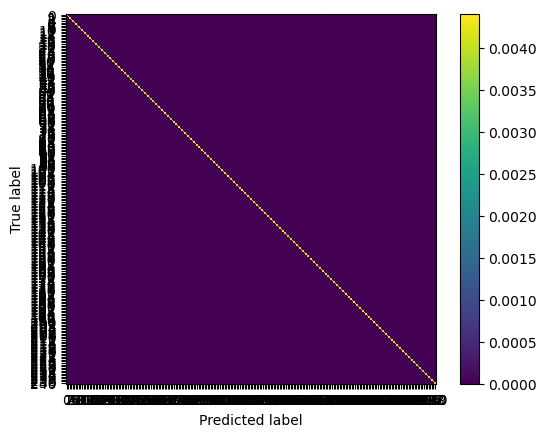

In [26]:
# Display confusion Matrix
y_pred = clf.predict(X_test)
plt.figure(figsize=(20,10))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,normalize='all',include_values=False)
# Show
plt.show()
plt.close()